---
# **LIBRARY**
---

In [3]:
# Library sistem
import os
import gdown
import shutil
import json

# Google spreadsheet API
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Library dasar
import numpy as np
import pandas as pd

# Library visualisasi
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Library pre-processing data
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Library statistika
from statsmodels.tsa.stattools import acf, pacf

# Library pemodelan
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional, GRU, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Library evaluasi
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Library penyetelan hiperparameter
# import optuna
# from optuna.visualization import (
#     plot_optimization_history,
#     plot_param_importances,
#     plot_parallel_coordinate,
#     plot_slice,
#     plot_contour
# )
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

---
# **CONFIGURATION**
---

In [40]:
# ============================
# Configuration
# ============================
# Path data input utama
METADATA_PATH = "../data/processed/(K3 - Transformasi per jam) Beban listrik.csv"  # Pastikan file sudah ada

# Path folder output utama
OUTPUT_PATH = "../hasil/pemodelan"

# File hasil eksperimen (log semua performa model)
EKSPERIMEN_EXCEL_PATH = f"{OUTPUT_PATH}/hasil_eksperimen.xlsx"

# Subfolder untuk hasil model
MODEL_PATH = f"{OUTPUT_PATH}/model"
HISTORY_PATH = f"{OUTPUT_PATH}/history"
GRAFIK_PATH = f"{OUTPUT_PATH}/grafik"
PREDIKSI_PATH = f"{OUTPUT_PATH}/prediksi"

# Buat semua direktori jika belum ada
for path in [OUTPUT_PATH, MODEL_PATH, HISTORY_PATH, GRAFIK_PATH, PREDIKSI_PATH, os.path.dirname(EKSPERIMEN_EXCEL_PATH)]:
    os.makedirs(path, exist_ok=True)

print(f"✅ Output directories ready under: {OUTPUT_PATH}")

✅ Output directories ready under: ../hasil/pemodelan


In [61]:
def simpan_eksperimen(data, file_path=EKSPERIMEN_EXCEL_PATH, sheet_name="raw"):
    # Pastikan direktori ada
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    kolom = [
        "time", "model", "time_step", "layer", "dense", "dropout_rate",
        "epochs", "batch_size",
        "train_mse", "test_mse", "train_mae", "test_mae",
        "train_rmse", "test_rmse", "train_mape", "test_mape",
        "train_r2", "test_r2"
    ]

    # Data baru
    time = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    df_new = pd.DataFrame([[time] + list(data)], columns=kolom)

    # Jika file dan sheet sudah ada → load & gabung
    if os.path.exists(file_path):
        try:
            df_lama = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
            df_all = pd.concat([df_lama, df_new], ignore_index=True)
        except Exception as e:
            print(f"⚠️ Error membaca sheet lama: {e}")
            df_all = df_new
        mode = "a"
        sheet_option = {"if_sheet_exists": "replace"}
    else:
        df_all = df_new
        mode = "w"
        sheet_option = {}

    # Simpan
    try:
        with pd.ExcelWriter(file_path, engine="openpyxl", mode=mode, **sheet_option) as writer:
            df_all.to_excel(writer, index=False, sheet_name=sheet_name)
        print(f"✅ Data berhasil disimpan ke sheet '{sheet_name}' di {file_path}")
    except Exception as e:
        print(f"❌ Gagal menyimpan data: {e}")


In [62]:
dummy_model = "LSTM"
dummy_timestep = 24
dummy_layer = 2
dummy_dense = [64, 32]
dummy_dropout = 0.2
dummy_epochs = 50
dummy_batch_size = 32

# Metric hasil pelatihan
dummy_train_mse = 0.001
dummy_test_mse = 0.002
dummy_train_mae = 0.01
dummy_test_mae = 0.015
dummy_train_rmse = 0.03
dummy_test_rmse = 0.04
dummy_train_mape = 2.1
dummy_test_mape = 2.5
dummy_train_r2 = 0.98
dummy_test_r2 = 0.97

# Gabungkan semuanya ke tuple sesuai urutan fungsi simpan_eksperimen()
data = (
    dummy_model, dummy_timestep, dummy_layer, dummy_dense,
    dummy_dropout, dummy_epochs, dummy_batch_size,
    dummy_train_mse, dummy_test_mse,
    dummy_train_mae, dummy_test_mae,
    dummy_train_rmse, dummy_test_rmse,
    dummy_train_mape, dummy_test_mape,
    dummy_train_r2, dummy_test_r2
)

# Panggil fungsi
simpan_eksperimen(data)

✅ Data berhasil disimpan ke sheet 'raw' di ../hasil/pemodelan/hasil_eksperimen.xlsx


---
# **LOAD METADATA**
---

In [82]:
# Memanggil data
df_siap = pd.read_csv(METADATA_PATH)
df_siap['TANGGAL_JAM'] = pd.to_datetime(df_siap['TANGGAL_JAM'])
df_siap['TAHUN'] = df_siap['TANGGAL_JAM'].dt.year

---
# **DEEP LEARNING**
---

## **Spliting Data**

In [45]:
def buat_dataset(data, time_step=1):
  X, y = [], []
  for i in range(len(data) - time_step):
    a = data[i:(i + time_step), 0]
    X.append(a)
    y.append(data[i + time_step, 0])
  return np.array(X), np.array(y)

def bagi_data(df, ukuran_pelatihan, time_step, scaler):
  data = df['BEBAN'].values.reshape(-1, 1)
  scaled_data = scaler.fit_transform(data)

  X, y = buat_dataset(scaled_data, time_step)

  X_train, X_test = X[:ukuran_pelatihan], X[ukuran_pelatihan:]
  y_train, y_test = y[:ukuran_pelatihan], y[ukuran_pelatihan:]

  train_data = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
  test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  return train_data, test_data, X_train, X_test, y_train, y_test, scaler

In [83]:
UKURAN_PELATIHAN = int(len(df_siap) * 0.8)
TIME_STEP = 24 #(1 hari)

train_data, test_data, X_train, X_test, y_train, y_test, scaler = bagi_data(df_siap, UKURAN_PELATIHAN, TIME_STEP, MinMaxScaler(feature_range=(0,1)))

In [84]:
print(f"Total : {len(df_siap)}")
print(f"Ukuran pelatihan : {UKURAN_PELATIHAN}")
print(f"X : {len(X_train) + len(X_test)}")
print(f"Train : {len(train_data)} ({len(X_train)},{len(y_train)})")
print(f"Test : {len(test_data)} ({len(X_test)},{len(y_test)})")

Total : 77857
Ukuran pelatihan : 62285
X : 77833
Train : 62285 (62285,62285)
Test : 15548 (15548,15548)


## **Pemodelan**

In [85]:
# Fungsi untuk membangun arsitektur model LSTM
def build_lstm(layer, dense, dropout_rate, time_step):
  model = Sequential()
  model.add(Input(shape=(time_step,1)))
  for i in range(0, layer):
      model.add(LSTM(dense[i], return_sequences=(i < layer - 1)))
      model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  return model, early_stopping

# Fungsi untuk membangun arsitektur model BiLSTM
def build_bilstm(layer, dense, dropout_rate, time_step):
  model = Sequential()
  model.add(Input(shape=(time_step,1)))
  for i in range(0, layer):
      model.add(Bidirectional(LSTM(dense[i],  return_sequences=(i < layer - 1))))
      model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  return model, early_stopping

# Fungsi untuk membangun arsitektur model GRU
def build_gru(layer, dense, dropout_rate, time_step):
  model = Sequential()
  model.add(Input(shape=(time_step,1)))
  for i in range(0, layer):
      model.add(GRU(dense[i], return_sequences=(i < layer - 1)))
      model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  return model, early_stopping

Model yang dibangun di bawah ini hanyalah model-model uji coba saja.

---
### **LSTM**
---

In [50]:
layer = 2
dense = [116, 104]
dropout_rate = 0.1
epochs = 3
batch_size = 512

model_lstm, early_stooping = build_lstm(layer, dense, dropout_rate, TIME_STEP)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 116)           54752     
                                                                 
 dropout (Dropout)           (None, 24, 116)           0         
                                                                 
 lstm_1 (LSTM)               (None, 104)               91936     
                                                                 
 dropout_1 (Dropout)         (None, 104)               0         
                                                                 
 dense (Dense)               (None, 1)                 105       
                                                                 
Total params: 146,793
Trainable params: 146,793
Non-trainable params: 0
_________________________________________________________________


In [51]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=1)

Epoch 1/3
122/122 [==============================] - 9s 39ms/step - loss: 0.0154 - val_loss: 0.0115
Epoch 2/3
122/122 [==============================] - 2s 19ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 3/3
122/122 [==============================] - 2s 20ms/step - loss: 0.0036 - val_loss: 0.0028


---
### **BiLSTM**
---

In [52]:
layer = 3
dense = [70,70,70]
dropout_rate = 0.110570919753144
epochs = 3
batch_size = 512

model_bilstm, early_stooping = build_bilstm(layer, dense, dropout_rate, TIME_STEP)
model_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 140)          40320     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 24, 140)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 140)          118160    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 140)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 140)              118160    
 nal)                                                            
                                                      

In [53]:
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=1)

Epoch 1/3
122/122 [==============================] - 14s 58ms/step - loss: 0.0131 - val_loss: 0.0072
Epoch 2/3
122/122 [==============================] - 6s 48ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/3
122/122 [==============================] - 6s 49ms/step - loss: 0.0030 - val_loss: 0.0025


---
### **GRU**
---

In [58]:
layer = 2
dense = [116, 104]
dropout_rate = 0.1
epochs = 3
batch_size = 512

model_gru, early_stooping = build_gru(layer, dense, dropout_rate, TIME_STEP)
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 24, 116)           41412     
                                                                 
 dropout_9 (Dropout)         (None, 24, 116)           0         
                                                                 
 gru_5 (GRU)                 (None, 104)               69264     
                                                                 
 dropout_10 (Dropout)        (None, 104)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 105       
                                                                 
Total params: 110,781
Trainable params: 110,781
Non-trainable params: 0
_________________________________________________________________


In [59]:
history_gru = model_gru.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=1)

Epoch 1/3
122/122 [==============================] - 4s 18ms/step - loss: 0.0129 - val_loss: 0.0047
Epoch 2/3
122/122 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 3/3
122/122 [==============================] - 2s 15ms/step - loss: 0.0024 - val_loss: 0.0021


## **Evaluasi**

In [76]:
def mae(y_true, y_pred, scaler):
    mae_scaled = mean_absolute_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mae_scaled, mae

def mse(y_true, y_pred, scaler):
    mse_scaled = mean_squared_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return mse_scaled, mse

def mape(y_true, y_pred, scaler):
    mape_scaled = mean_absolute_percentage_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mape_scaled, mape

def rmse(y_true, y_pred, scaler):
    rmse_scaled = root_mean_squared_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return rmse_scaled, rmse

def r2(y_true, y_pred, scaler):
    r2_scaled = r2_score(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    r2 = r2_score(y_true, y_pred)
    return r2, r2_scaled

In [77]:
def plot_evaluasi(time, data_asli, train_predict, test_predict, scaler, title, filename="test", type="trial", time_step=TIME_STEP):
    prediksi_path = f"{PREDIKSI_PATH}/{time_step}/{type}"
    grafik_path = f"{GRAFIK_PATH}/{time_step}/{type}"

    for path in [prediksi_path, grafik_path]:
        os.makedirs(path, exist_ok=True)

    train_predict_rescaled = scaler.inverse_transform(train_predict)
    test_predict_rescaled = scaler.inverse_transform(test_predict)

    empty_values = np.full((time_step, train_predict_rescaled.shape[1]), np.nan)  # Membuat array kosong (NaN) dengan panjang 24
    train_predict_rescaled = np.concatenate((empty_values, train_predict_rescaled), axis=0)

    # Menggabungkan prediksi pelatihan dengan prediksi pengujian
    all_data = np.concatenate((train_predict_rescaled, test_predict_rescaled), axis=0).reshape(-1)

    # Membuat DataFrame dengan kolom waktu dan nilai yang sesuai
    predictions_df = pd.DataFrame({
        'time': time,
        'data_asli': data_asli,
        'prediksi': all_data
    })

    predictions_df.to_csv(f"{prediksi_path}/{filename}.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.plot(time, data_asli, color='b', label='Data asli', lw=0.5)
    plt.plot(time[time_step:len(train_predict)+time_step], scaler.inverse_transform(train_predict), color='orange', label='Prediksi data pelatihan', alpha=0.95, lw=0.5)
    plt.plot(time[len(train_predict)+time_step:len(data_asli)], scaler.inverse_transform(test_predict), color='r', label='Prediksi data pengujian', alpha=0.95,lw=0.5)
    plt.xlabel('Tanggal')
    plt.xticks(rotation=90)
    plt.ylabel('Beban Listrik (MW)')
    plt.title(f"Prediksi {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{grafik_path}/{filename}.png")
    plt.savefig(f"{grafik_path}/{filename}.pdf")
    plt.show()

In [88]:
def plot_prediksi(time, data_asli, train_predict, test_predict, scaler, days, title, filename="test", type="trial", time_step=TIME_STEP):
    grafik_path = f"{GRAFIK_PATH}/{time_step}/{type}"
    os.makedirs(grafik_path, exist_ok=True)
    
    n_data = len(train_predict)+len(test_predict)
    plt.figure(figsize=(10, 6))
    plt.plot(time[n_data-days+time_step:n_data+days+time_step], data_asli[n_data-days+time_step:n_data+days+time_step], color='b', label='Data asli')
    plt.plot(time[n_data-days+time_step:n_data+days+time_step], scaler.inverse_transform(test_predict)[len(test_predict)-days:len(test_predict)], color='r', label='Prediksi data pengujian', alpha=0.8)
    plt.xlabel('Tanggal')
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=days)
    plt.ylabel('Beban Listrik (MW)')
    plt.title(f"Model {title}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{grafik_path}/{filename}.png")
    plt.savefig(f"{grafik_path}/{filename}.pdf")
    plt.show()

In [89]:
def plot_loss(history, epochs, title, filename="test", type="trial", time_step=TIME_STEP):
    grafik_path = f"{GRAFIK_PATH}/{time_step}/{type}"
    os.makedirs(grafik_path, exist_ok=True)

    plt.plot(history.history['loss'][:epochs], label='Error pelatihan')
    plt.plot(history.history['val_loss'][:epochs], label='Eror pengujian')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.savefig(f"{grafik_path}/{filename}.png")
    plt.savefig(f"{grafik_path}/{filename}.pdf")
    plt.show()

---
### **LSTM**
---

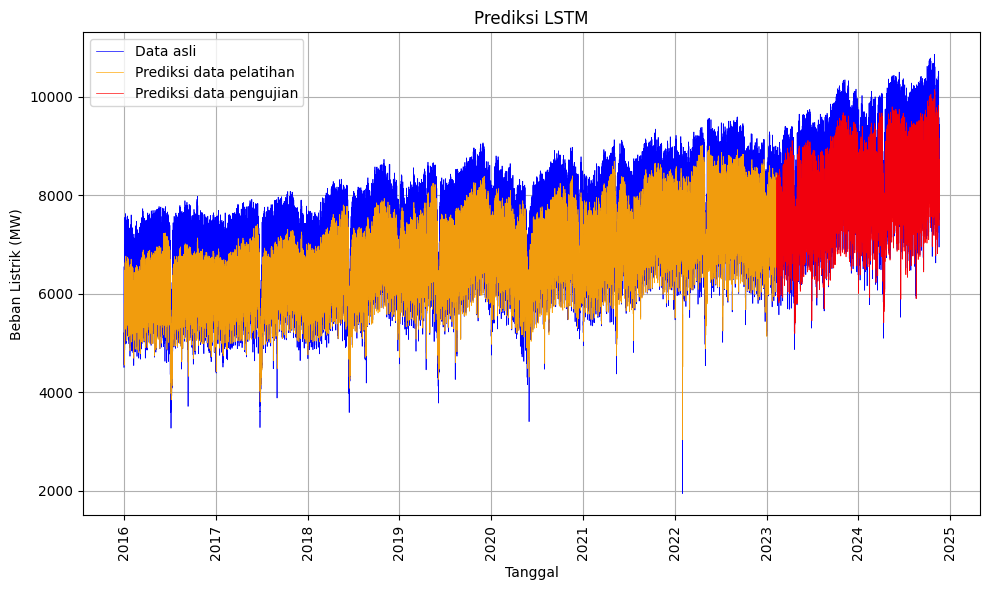

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_7132\1031969864.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=days)


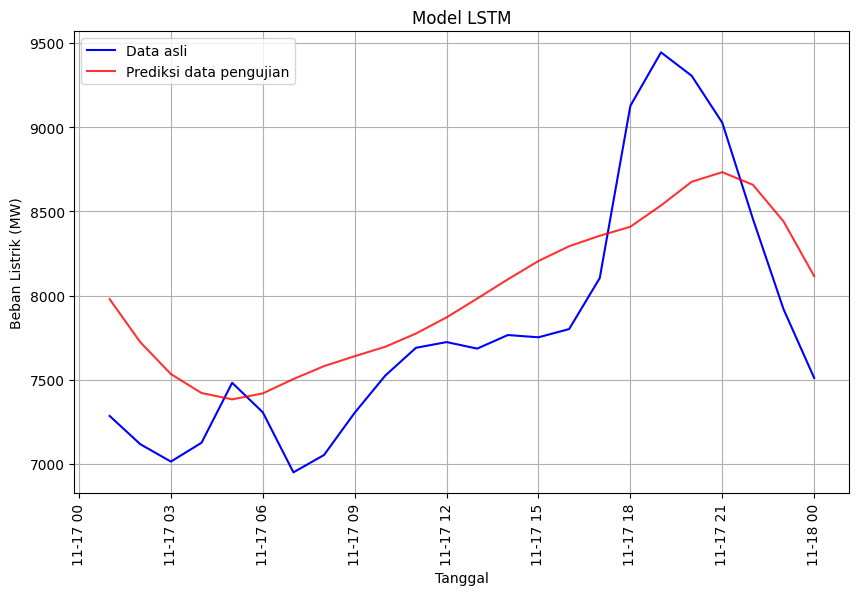

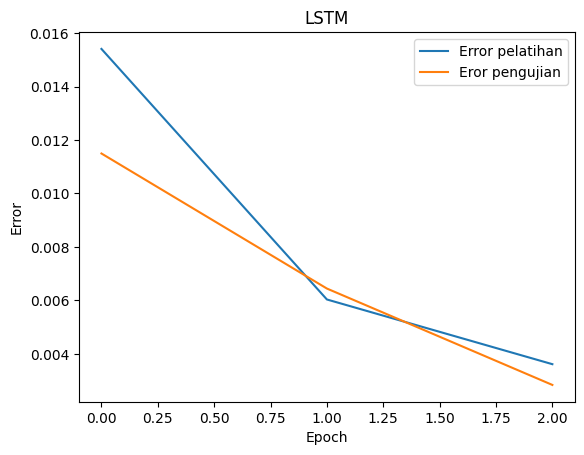

In [97]:
train_predict_lstm = model_lstm.predict(X_train, verbose=0)
test_predict_lstm = model_lstm.predict(X_test, verbose=0)

title = "LSTM"
type = "trial"
best_epochs = np.argmin(history_lstm.history['val_loss']) + 1
history = history_lstm
train_predict = train_predict_lstm
test_predict = test_predict_lstm
days = TIME_STEP

plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="LSTM_train_test", type=type, time_step=TIME_STEP)
plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="LSTM_test", type=type, time_step=TIME_STEP)
plot_loss(history=history, epochs=best_epochs, title=title, filename="LSTM_Loss", type=type, time_step=TIME_STEP)

---
### **BiLSTM**
---

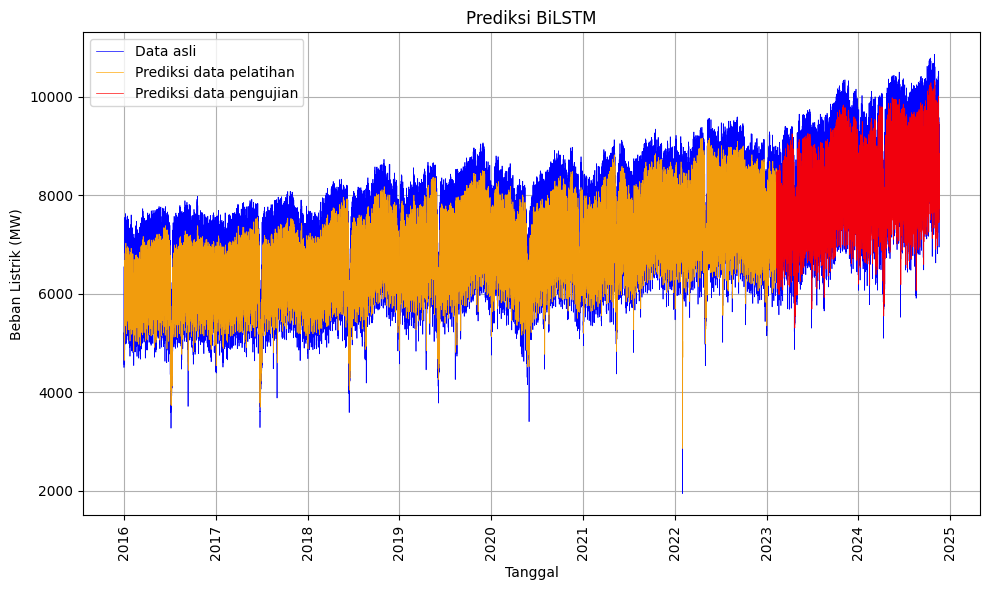

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_7132\1031969864.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=days)


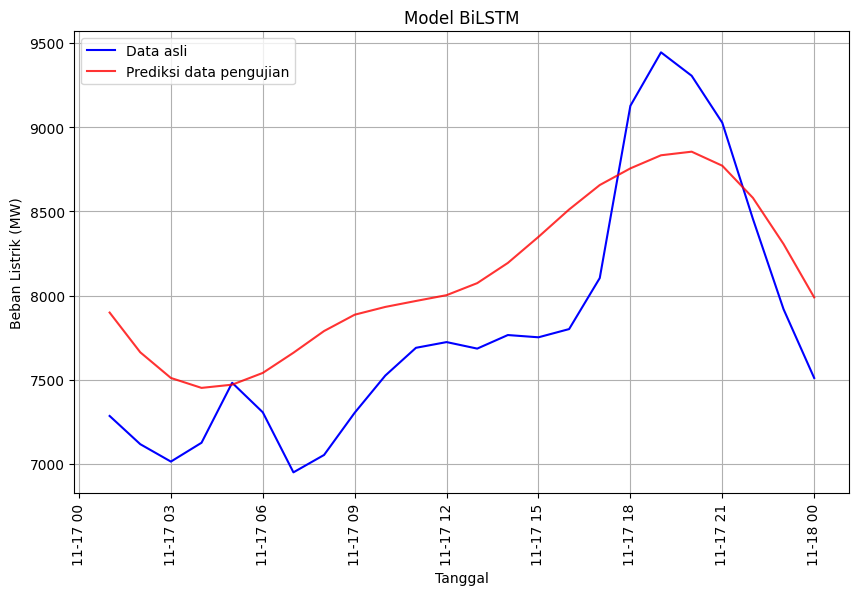

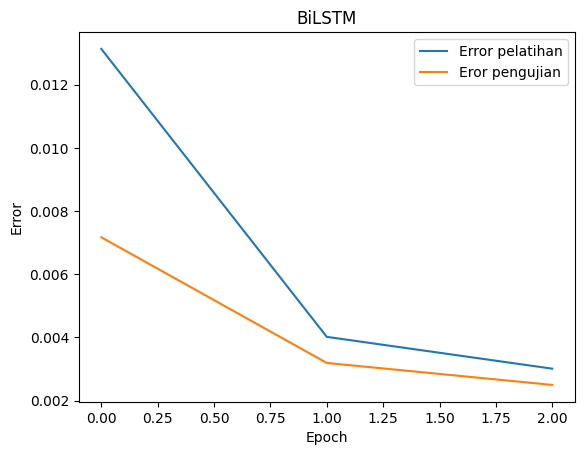

In [99]:
train_predict_bilstm = model_bilstm.predict(X_train, verbose=0)
test_predict_bilstm = model_bilstm.predict(X_test, verbose=0)

title = "BiLSTM"
type = "trial"
best_epochs = np.argmin(history_bilstm.history['val_loss']) + 1
history = history_bilstm
train_predict = train_predict_bilstm
test_predict = test_predict_bilstm
days = TIME_STEP

plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="BiLSTM_train_test", type=type, time_step=TIME_STEP)
plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="BiLSTM_test", type=type, time_step=TIME_STEP)
plot_loss(history=history, epochs=best_epochs, title=title, filename="BiLSTM_Loss", type=type, time_step=TIME_STEP)

---
### **GRU**
---

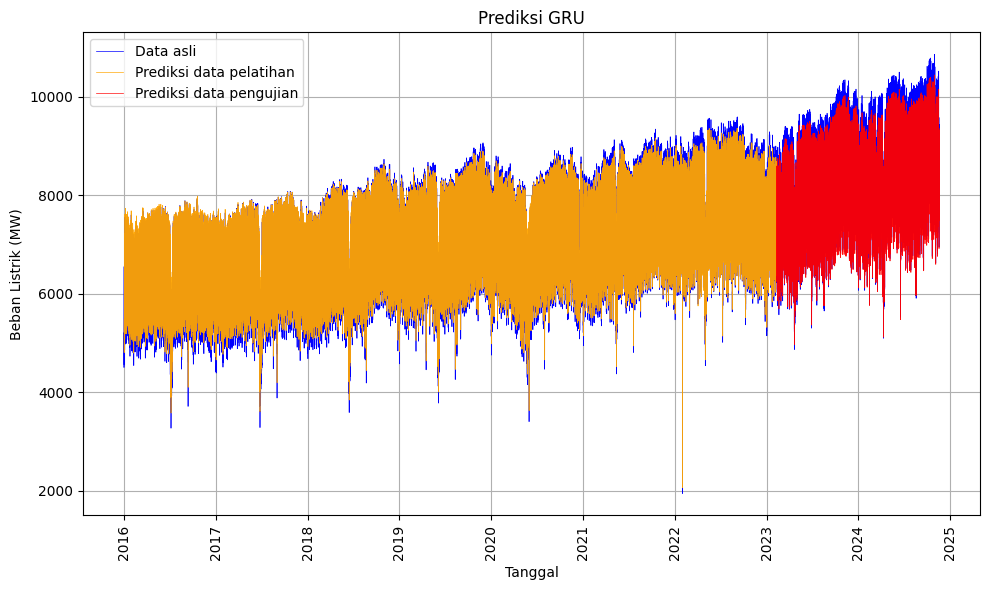

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_7132\1031969864.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=days)


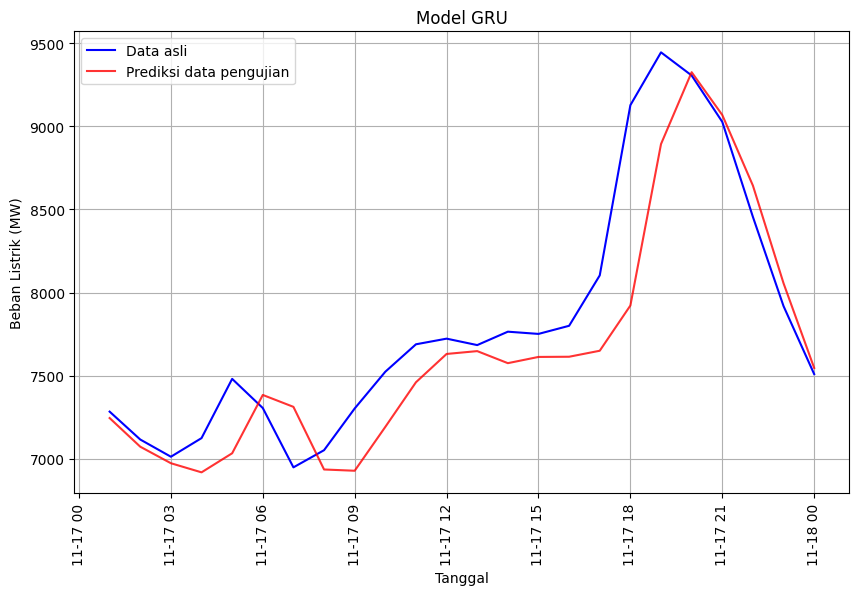

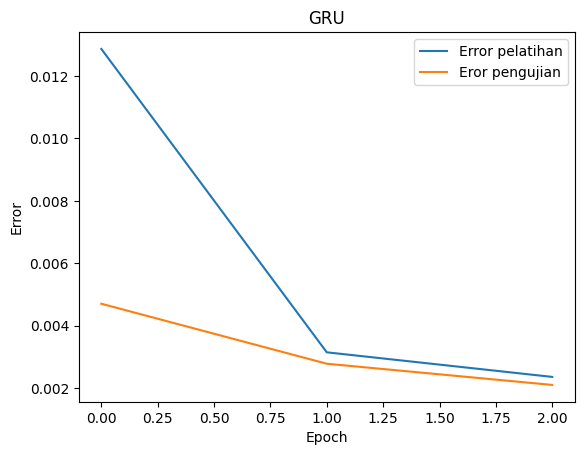

In [100]:
train_predict_gru = model_gru.predict(X_train, verbose=0)
test_predict_gru = model_gru.predict(X_test, verbose=0)

title = "GRU"
type = "trial"
best_epochs = np.argmin(history_gru.history['val_loss']) + 1
history = history_gru
train_predict = train_predict_gru
test_predict = test_predict_gru
days = TIME_STEP

plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="GRU_train_test", type=type, time_step=TIME_STEP)
plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="GRU_test", type=type, time_step=TIME_STEP)
plot_loss(history=history, epochs=best_epochs, title=title, filename="GRU_Loss", type=type, time_step=TIME_STEP)

In [80]:
def simpan_histori(history_data, filename="test", type="trial", time_step=TIME_STEP):
    history_path = f"{HISTORY_PATH}/{time_step}/{type}"
    os.mkdir(history_path, exist_ok=True)
    
    loss_history = history_data.history['loss']
    val_loss_history = history_data.history['val_loss']
    epochs = range(1, len(loss_history) + 1)

    best_epoch = min(range(len(val_loss_history)), key=val_loss_history.__getitem__) + 1
    best_val_loss = min(val_loss_history)

    df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': loss_history,
        'Validation Loss': val_loss_history
    })

    best_epoch_data = pd.DataFrame({
        'Epoch': [best_epoch],
        'Training Loss': [None],
        'Validation Loss': [best_val_loss]
    })

    # Concatenate best epoch row
    df = pd.concat([df, best_epoch_data], ignore_index=True)    
    df.to_csv(f'{history_path}/{filename}.csv', index=False)

    return df

def evaluasi(X_train, X_test, y_train, y_test, time_step, model, scaler, save=[False], verbose=False):
    train_predict = model.predict(X_train, verbose=0)
    test_predict = model.predict(X_test, verbose=0)

    train_data_new = y_train.reshape(-1, 1)
    test_data_new = y_test.reshape(-1, 1)

    mae_train_scaled, mae_train = mae(train_data_new,train_predict,scaler)
    mae_test_scaled, mae_test = mae(test_data_new,test_predict,scaler)
    mse_train_scaled, mse_train = mse(train_data_new,train_predict,scaler)
    mse_test_scaled, mse_test = mse(test_data_new,test_predict,scaler)
    rmse_train_scaled, rmse_train = rmse(train_data_new,train_predict,scaler)
    rmse_test_scaled, rmse_test = rmse(test_data_new,test_predict,scaler)
    mape_train_scaled, mape_train = mape(train_data_new,train_predict,scaler)
    mape_test_scaled, mape_test = mape(test_data_new,test_predict,scaler)
    r2_train = r2(train_data_new,train_predict,scaler)
    r2_test = r2(test_data_new,test_predict,scaler)

    if(save[0]):
        print("Saving history")
        _, model, time_step, layer, dense, dropout_rate, epochs, batch_size = save
        history = [model, time_step, layer, str(dense), dropout_rate, epochs, batch_size, mse_train, mse_test, mae_train, mae_test, rmse_train, rmse_test, mape_train, mape_test, r2_train, r2_test]

        try:
            simpan_eksperimen(history)
        except Exception as e:
            print(f"Error appending row: {e}")

    if(verbose):
        print("Matriks Evaluasi : Train\tTest")
        print(f"MSE : {mse_train}\t{mse_test}")
        print(f"MAE : {mae_train}\t{mae_test}")
        print(f"RMSE : {rmse_train}\t{rmse_test}")
        print(f"MAPE : {mape_train}\t{mape_test}")
        print(f"R2 : {r2_train}\t{r2_test}")
        return mae_train, mae_test

    return mse_train, mse_test

In [10]:



def plot_prediksi_df(title, time, data, predict, time_step, day1, day2, alpha, lw):
    plt.figure(figsize=(16,5))
    ukuran_pelatihan = int(len(data)*0.8)

    if ukuran_pelatihan < day1:
        ukuran_pelatihan = day1

    if ukuran_pelatihan > day2:
        ukuran_pelatihan = day2

    plt.plot(time[day1:day2], data[day1:day2], color='blue', label='Data asli')

    if ukuran_pelatihan > day1:
        plt.plot(time[day1:ukuran_pelatihan], predict[day1:ukuran_pelatihan], color='orange', label='Prediksi data latih', alpha=alpha, lw=lw)
    if ukuran_pelatihan < day2:
        plt.plot(time[ukuran_pelatihan:day2], predict[ukuran_pelatihan:day2], color='red', label='Prediksi data uji', alpha=alpha, lw=lw)

    plt.xlabel('Tanggal')
    plt.xticks(rotation=45)
    plt.ylabel('Beban Listrik (MW)')
    plt.title(f"Prediksi {title[0]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Output/Grafik/Evaluasi/{title[1]}.png")
    plt.savefig(f"Output/Grafik/Evaluasi/{title[1]}.pdf")
    plt.show()

def plot_loss_df(title, history, epochs):
    plt.plot(history['Training Loss'][:epochs], label='Error pelatihan')
    plt.plot(history['Validation Loss'][:epochs], label='Eror pengujian')
    plt.title(f"Kurva pelatihan {title[0]}")
    plt.xlabel('Epoch')
    plt.ylabel('Error (MSE data normalisasi)')
    plt.legend()
    plt.savefig(f"Output/Grafik/Evaluasi/{title[1]}.png")
    plt.savefig(f"Output/Grafik/Evaluasi/{title[1]}.pdf")
    plt.show()

def plot_loss_gabungan(df_lstm, df_bilstm, df_gru, time_step, ep1,ep2):
    # Mengambil data epoch dan loss pelatihan dan pengujian dari dataframe
    epochs_lstm = df_lstm['Epoch']
    loss_lstm_train = df_lstm['Training Loss']
    loss_lstm_val = df_lstm['Validation Loss']

    epochs_bilstm = df_bilstm['Epoch']
    loss_bilstm_train = df_bilstm['Training Loss']
    loss_bilstm_val = df_bilstm['Validation Loss']

    epochs_gru = df_gru['Epoch']
    loss_gru_train = df_gru['Training Loss']
    loss_gru_val = df_gru['Validation Loss']

    # Membuat plot
    plt.figure(figsize=(10, 6))

    # # # Plot Loss Pelatihan
    # plt.plot(epochs_lstm[ep1:ep2], loss_lstm_train[ep1:ep2], label='LSTM', color='blue')
    # plt.plot(epochs_bilstm[ep1:ep2], loss_bilstm_train[ep1:ep2], label='BiLSTM', color='orange')
    # plt.plot(epochs_gru[ep1:ep2], loss_gru_train[ep1:ep2], label='GRU', color='green')

    # Plot Loss Pengujian
    plt.plot(epochs_lstm[ep1:ep2], loss_lstm_val[ep1:ep2], label='SSA-LSTM', color='blue')
    plt.plot(epochs_bilstm[ep1:ep2], loss_bilstm_val[ep1:ep2], label='SSA-BiLSTM', color='orange')
    plt.plot(epochs_gru[ep1:ep2], loss_gru_val[ep1:ep2], label='SSA-GRU', color='green')

    # Menambahkan Label dan Legenda
    plt.title(f'Kurva pelatihan SSA-LSTM, SSA-BiLSTM, and SSA-GRU (time step {time_step})')
    plt.xlabel('Epochs')
    plt.ylabel('Error (MSE data normalisasi)')

    if ep1 == 0:
        plt.legend()

    plt.savefig(f"Output/Grafik/Evaluasi/Best/loss_latih_gabungan_{time_step}.png")
    plt.savefig(f"Output/Grafik/Evaluasi/Best/loss_latih_gabungan_{time_step}.pdf")
    plt.show()